# Chemical and cancer phases analysis

## libraries import

In [1]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

from src.drugbank_XML_drugparser import DrugParser
from src.drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from src.preprocessing import Preprocessing, ColumnClean

from matplotlib.patches import Circle
import matplotlib.patches as mpatches

from src.data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Dataframes imports

In [2]:
# loads bindingDB and Drugbank merged
merged_df = pd.read_pickle(MERGED)

In [3]:
merged_df.columns

Index(['ki', 'ph', 'temp', 'ic50', 'ec50', 'kd', 'kon', 'koff', 'doi',
       'target_name', 'ligand_name', 'pubchem_cid', 'chebi_id', 'chembl_id',
       'drugbank_id', 'kegg_id', 'zinc_id', 'smiles', 'inchi_key',
       'bindingdb_id', 'swissprot_target_chain_name',
       'swissprot_target_chain_entry_name', 'swissprot_protein_id',
       'Unique_ID', 'drugbank_drug_name', 'drugbank_drug_unii',
       'drugbank_drug_toxicity', 'drugbank_drug_class_kingdom',
       'drugbank_drug_class_superclass', 'drugbank_drug_synonyms',
       'drugbank_drug_categories', 'drugbank_drug_patent_approved',
       'drugbank_drug_interaction', 'Matched_On', 'drugbank_protein_name',
       'drugbank_protein_general_function',
       'drugbank_protein_specific_function', 'drugbank_protein_organism'],
      dtype='object')

In [4]:
# loads cancerous protein dataframe
protein_classes = pd.read_csv("data/clean/protein_class_COSMIC.tsv", sep='\t')

for col in protein_classes.columns:
    print(col)
protein_classes

Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificity score
RNA single cell type specific nTPM
RNA single nuclei brain specificity
RNA single nuclei brain distribution
RNA single nuclei brain specificity score
RNA single nuclei brain specific nTPM
RNA cancer specificity
RNA cancer distribution
RNA cancer specificity score
RNA cancer specific FPKM
RNA brain regional specificity
RNA brain regional distribution
RNA brain regional specificity score
RNA brain regional specific nTPM
RNA blood cell specificity
RNA blood cell distribution
RNA blood cell specificity score
RNA blood cell specific nTPM
RNA blood lineage specificity
RNA blood lineage distri

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Cancer prognostics - Pancreatic Adenocarcinoma (TCGA),Cancer prognostics - Pancreatic Adenocarcinoma (validation),Cancer prognostics - Prostate Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (TCGA),Cancer prognostics - Rectum Adenocarcinoma (validation),Cancer prognostics - Skin Cuteneous Melanoma (TCGA),Cancer prognostics - Stomach Adenocarcinoma (TCGA),Cancer prognostics - Testicular Germ Cell Tumor (TCGA),Cancer prognostics - Thyroid Carcinoma (TCGA),Cancer prognostics - Uterine Corpus Endometrial Carcinoma (TCGA)
0,ABI1,"ABI-1, E3B1, SSH3BP1",ENSG00000136754,Abl interactor 1,Q8IZP0,10,26746593-26861087,"Cancer-related genes, Disease related genes, P...",Host-virus interaction,NaN,...,unprognostic (6.17e-3),unprognostic (9.66e-2),unprognostic (8.60e-2),unprognostic (1.16e-1),unprognostic (3.28e-2),unprognostic (1.01e-1),unprognostic (3.66e-1),unprognostic (1.72e-1),unprognostic (1.03e-1),unprognostic (1.72e-1)
1,ABL1,"ABL, c-ABL, JTK7, p150",ENSG00000097007,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,9,130713043-130887675,"Cancer-related genes, Disease related genes, E...","Apoptosis, Autophagy, Cell adhesion, DNA damag...","DNA-binding, Kinase, Transferase, Tyrosine-pro...",...,unprognostic (6.12e-2),unprognostic (3.31e-2),unprognostic (1.27e-1),unprognostic (2.01e-2),unprognostic (2.18e-1),unprognostic (2.61e-1),unprognostic (8.92e-2),unprognostic (3.15e-1),unprognostic (1.29e-1),unprognostic (1.96e-2)
2,ABL2,"ABLL, ARG",ENSG00000143322,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1,179099330-179229684,"Cancer-related genes, Enzymes, Predicted intra...",Cell adhesion,"Kinase, Transferase, Tyrosine-protein kinase",...,unprognostic (2.27e-2),unprognostic (1.90e-3),unprognostic (1.86e-1),unprognostic (1.08e-1),unprognostic (7.21e-2),unprognostic (2.24e-1),unprognostic (9.34e-2),unprognostic (1.59e-1),unprognostic (2.71e-2),unprognostic (5.39e-2)
3,ACKR3,"CMKOR1, CXCR7, GPR159, RDC1",ENSG00000144476,Atypical chemokine receptor 3,P25106,2,236567787-236582354,"Cancer-related genes, Disease related genes, G...","Cell adhesion, Host-virus interaction","Developmental protein, G-protein coupled recep...",...,unprognostic (1.48e-3),unprognostic (8.51e-2),unprognostic (3.54e-2),unprognostic (1.21e-1),unprognostic (4.76e-3),unprognostic (1.29e-2),unprognostic (1.95e-4),unprognostic (1.41e-1),unprognostic (1.15e-3),unprognostic (4.99e-2)
4,ACSL3,"ACS3, FACL3, PRO2194",ENSG00000123983,Acyl-CoA synthetase long chain family member 3,O95573,2,222860942-222944639,"Cancer-related genes, Enzymes, Metabolic prote...","Fatty acid metabolism, Lipid metabolism",Ligase,...,unprognostic (7.65e-2),unprognostic (1.24e-1),unprognostic (2.88e-2),unprognostic (3.03e-1),unprognostic (2.64e-2),unprognostic (8.26e-2),unprognostic (9.29e-2),unprognostic (1.77e-1),unprognostic (1.08e-1),unprognostic (2.19e-1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,ZMYM2,"FIM, MYM, RAMP, ZNF198",ENSG00000121741,Zinc finger MYM-type containing 2,Q9UBW7,13,19958677-20091829,"Cancer-related genes, Disease related genes, H...","Transcription, Transcription regulation",NaN,...,unprognostic (3.57e-2),unprognostic (4.85e-1),unprognostic (1.21e-1),unprognostic (4.77e-2),unprognostic (1.74e-1),unprognostic (7.15e-2),unprognostic (2.15e-1),unprognostic (1.08e-1),unprognostic (3.70e-3),unprognostic (1.30e-1)
568,ZNF331,"RITA, ZNF361, ZNF463",ENSG00000130844,Zinc finger protein 331,Q9NQX6,19,53519527-53580269,"Cancer-related genes, Predicted intracellular ...","Transcription, Transcription regulation",DNA-binding,...,unprognostic (1.35e-2),unprognostic (4.71e-2),unprognostic (4.12e-1),unprognostic (2.69e-1),unprognostic (5.47e-3),unprognostic (1.28e-2),unprognostic (1.03e-3),unprognostic (1.42e-1),unprognostic (2.32e-4),unprognostic (3.34e-2)
569,ZNF384,"CAGH1A, C

In [5]:
# Additional proteins 
highly_studied_proteins = [
    'Cytochrome P450 3A4', 
    'Epidermal growth factor receptor', 
    'Proto-oncogene tyrosine-protein kinase Src', 
    'Vascular endothelial growth factor receptor 2', 
    'Adenosine receptor A2a', 'Cytochrome P450 2C9', 
    'Cytochrome P450 1A2', 'Cytochrome P450 2C19', 
    'Cytochrome P450 2D6', 
    'Prostaglandin G/H synthase 1', 
    'Prostaglandin G/H synthase 2'
    ]

In [6]:
# create lists of the relevant columns to identify cancerous proteins
cancer_proteins = list(protein_classes["Gene"].dropna().values)
genes_uniprot = list(protein_classes["Uniprot"].astype(str).dropna().values)

In [7]:
# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)
pattern_gene_names =  '|'.join(rf"\b{re.escape(term)}\b" for term in genes_uniprot)
pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
filtered_df = merged_df[
    #merged_df['drugbank_drug_unii'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_protein_id'].str.contains(pattern_gene_names, case=False, na=False) |
    #merged_df['drugbank_protein_name'].str.contains(pattern_protein_names, case=False, na=False)|
    #merged_df['target_name'].str.contains(pattern_highly_studied, case=False, na=False)
    merged_df['target_name'].isin(highly_studied_proteins)
]
filtered_df.reset_index(inplace=True)


print(filtered_df.shape)
filtered_df.head()

(103259, 39)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
0,142,<NA>,<NA>,<NA>,50000.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775,<NA>,7.5,20.0,800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3776,<NA>,7.5,20.0,220.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3777,<NA>,7.5,20.0,160.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3778,<NA>,7.5,20.0,58.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Create a new column to distinguish rows with and without `drugbank_drug_name`
filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})

C:\Users\godenzi\AppData\Local\Temp\ipykernel_12604\4122900635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['drugbank_drug_name_present'] = filtered_df['drugbank_drug_name'].notna().map({True: 'With DrugBank Drug', False: 'Without DrugBank Drug'})


# Chemical metrics of affinity

## First look 

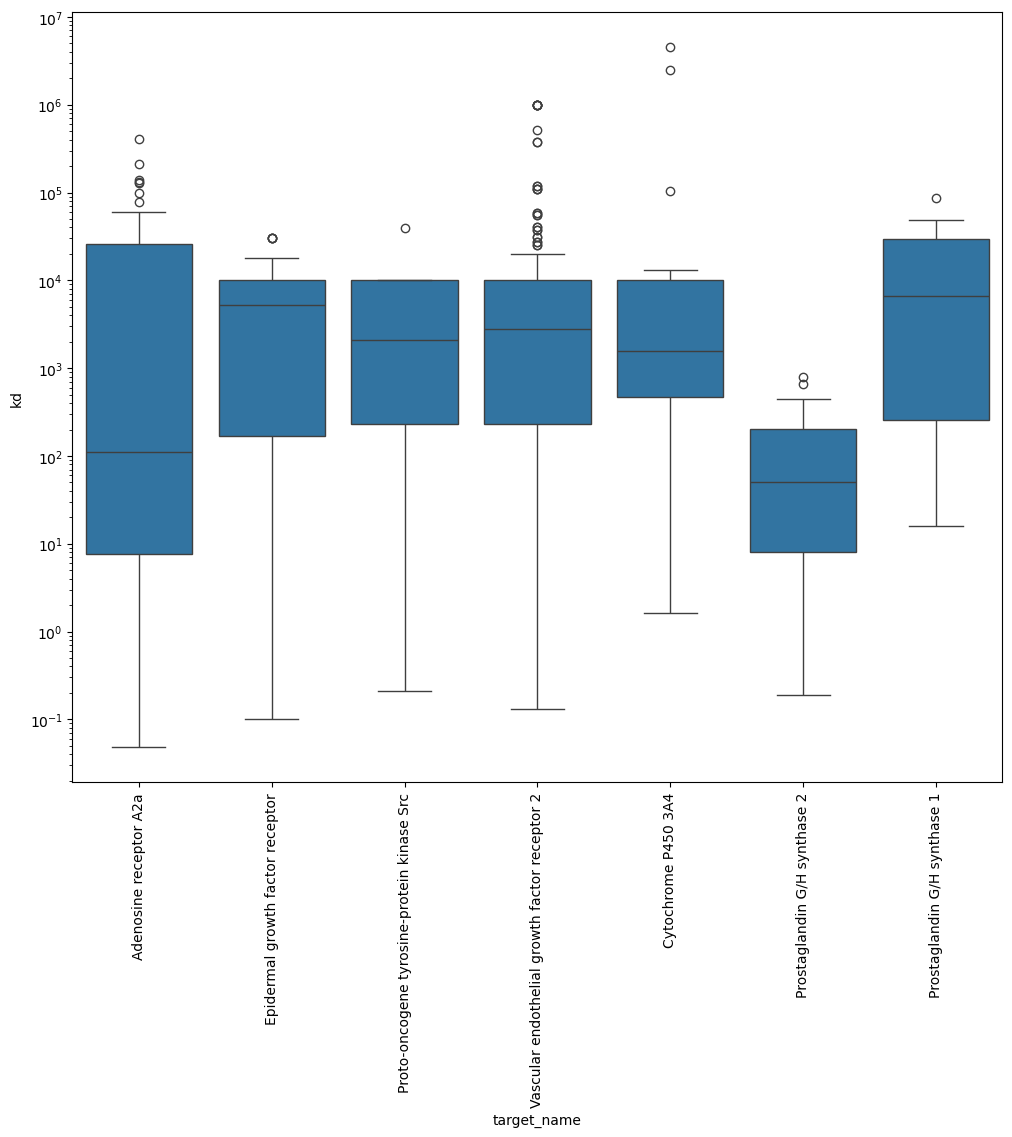

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(data=filtered_df[filtered_df.kd.notna()], x="target_name", y="kd")
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

### ki 

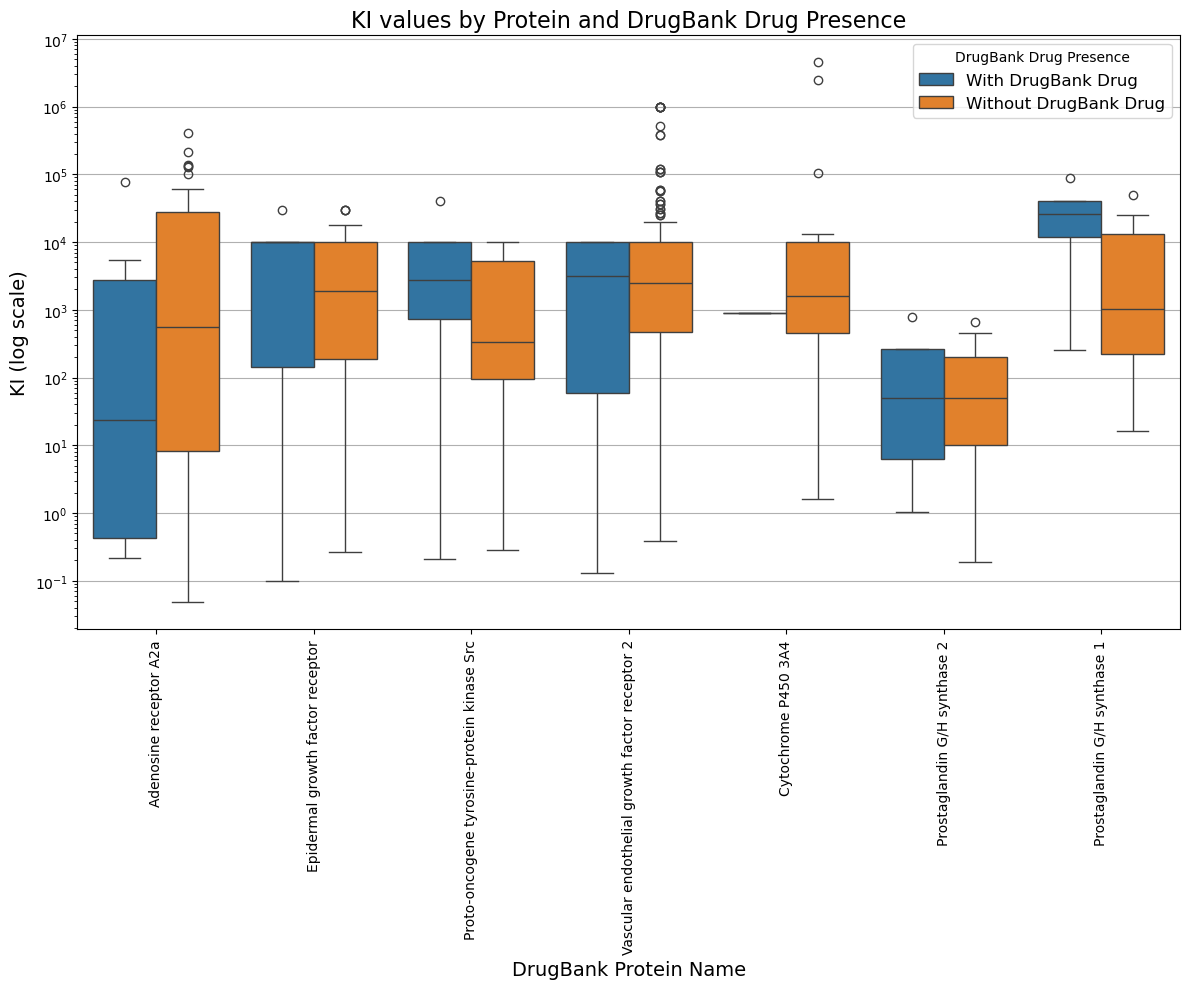

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ki'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ki",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("KI values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("KI (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid(axis="y")
plt.show()


### IC50

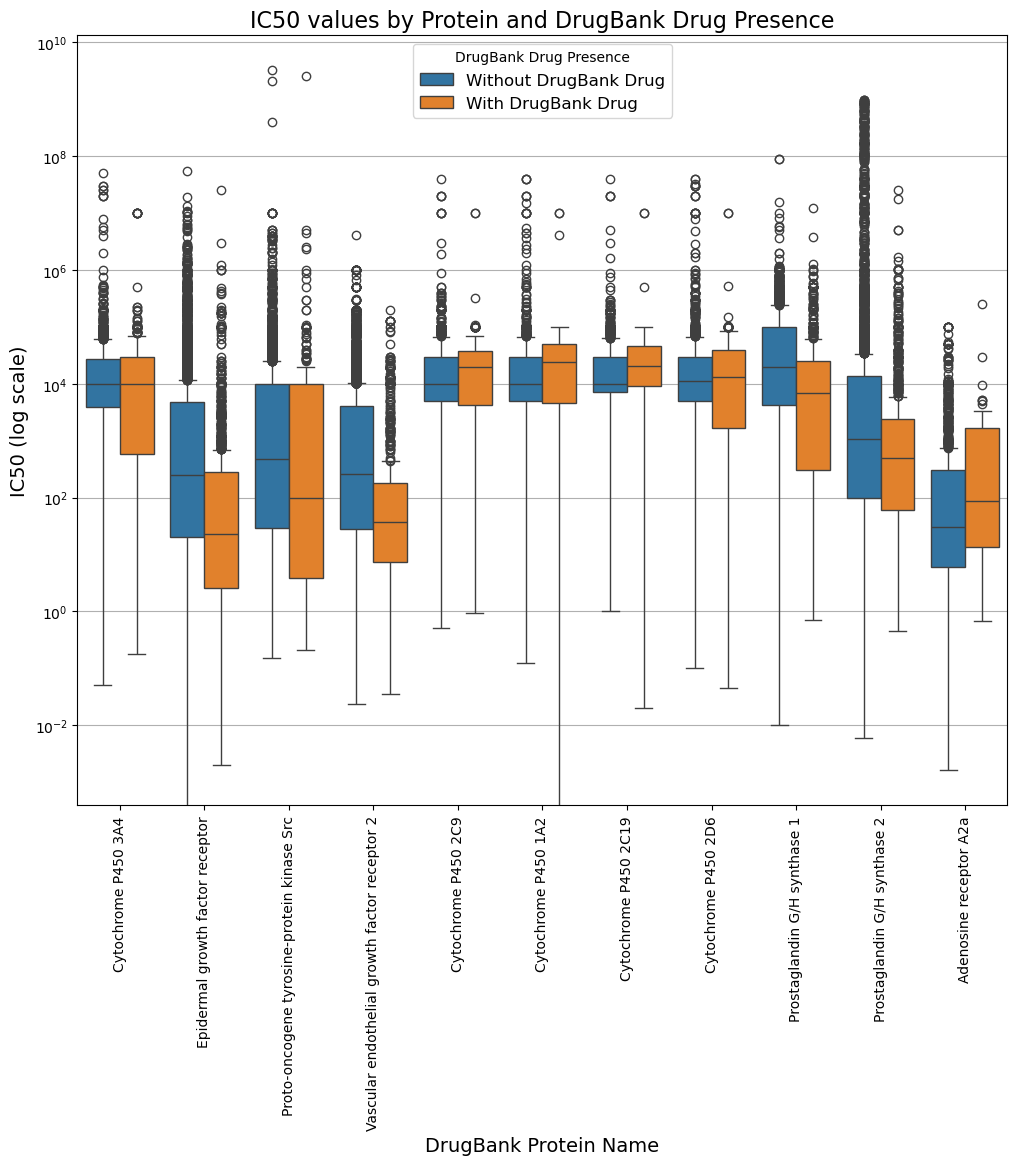

In [11]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ic50'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ic50",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("IC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("IC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
#plt.tight_layout()
plt.grid(axis="y")
plt.show()


### EC50

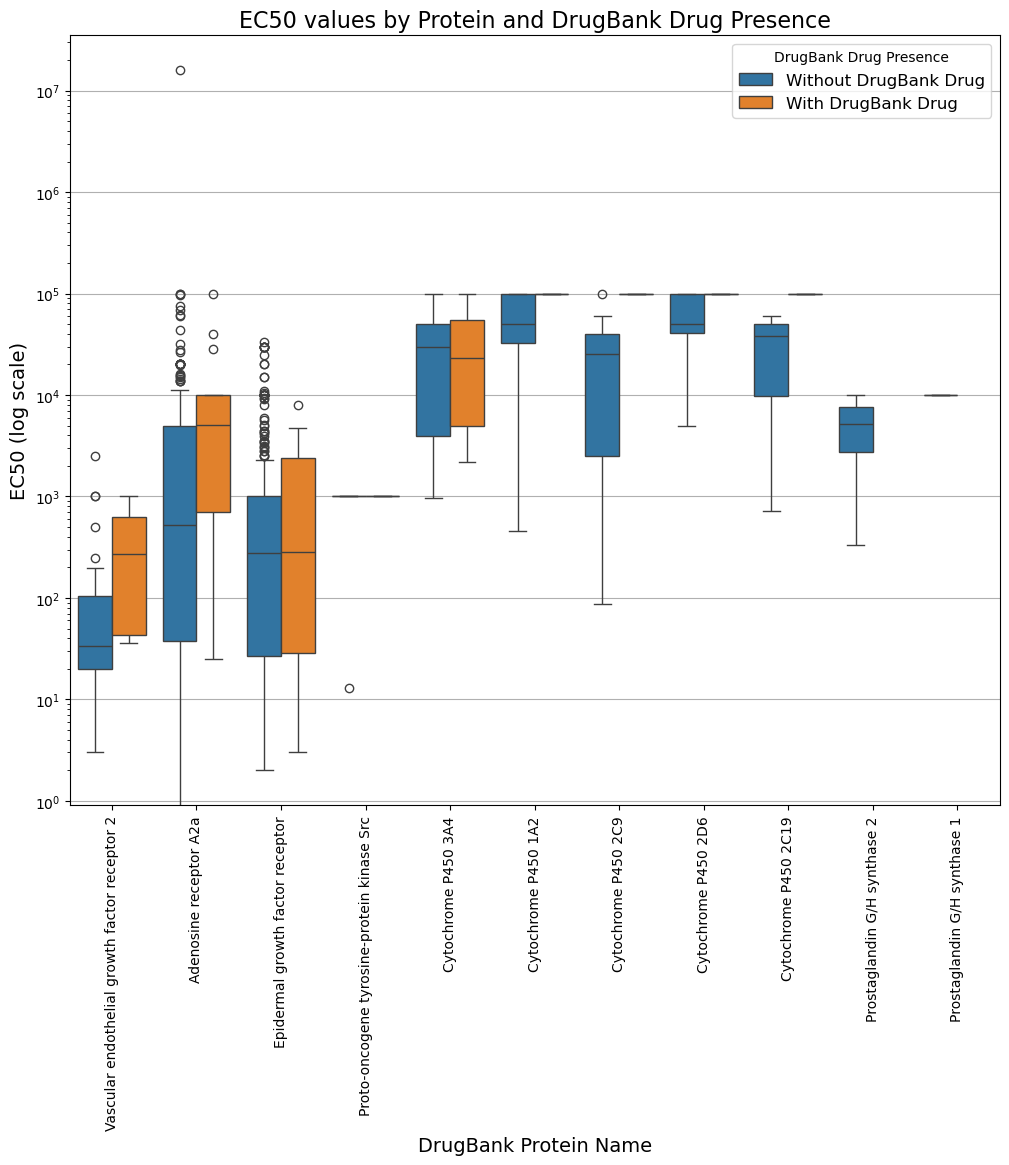

In [35]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ec50'].notna()].drop_duplicates(),  # Exclude rows with NaN `ki`
    x="target_name",
    y="ec50",
    hue="drugbank_drug_name_present",  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("EC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("EC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
#plt.tight_layout()
plt.grid(axis="y")
plt.show()

#### Naive plotting

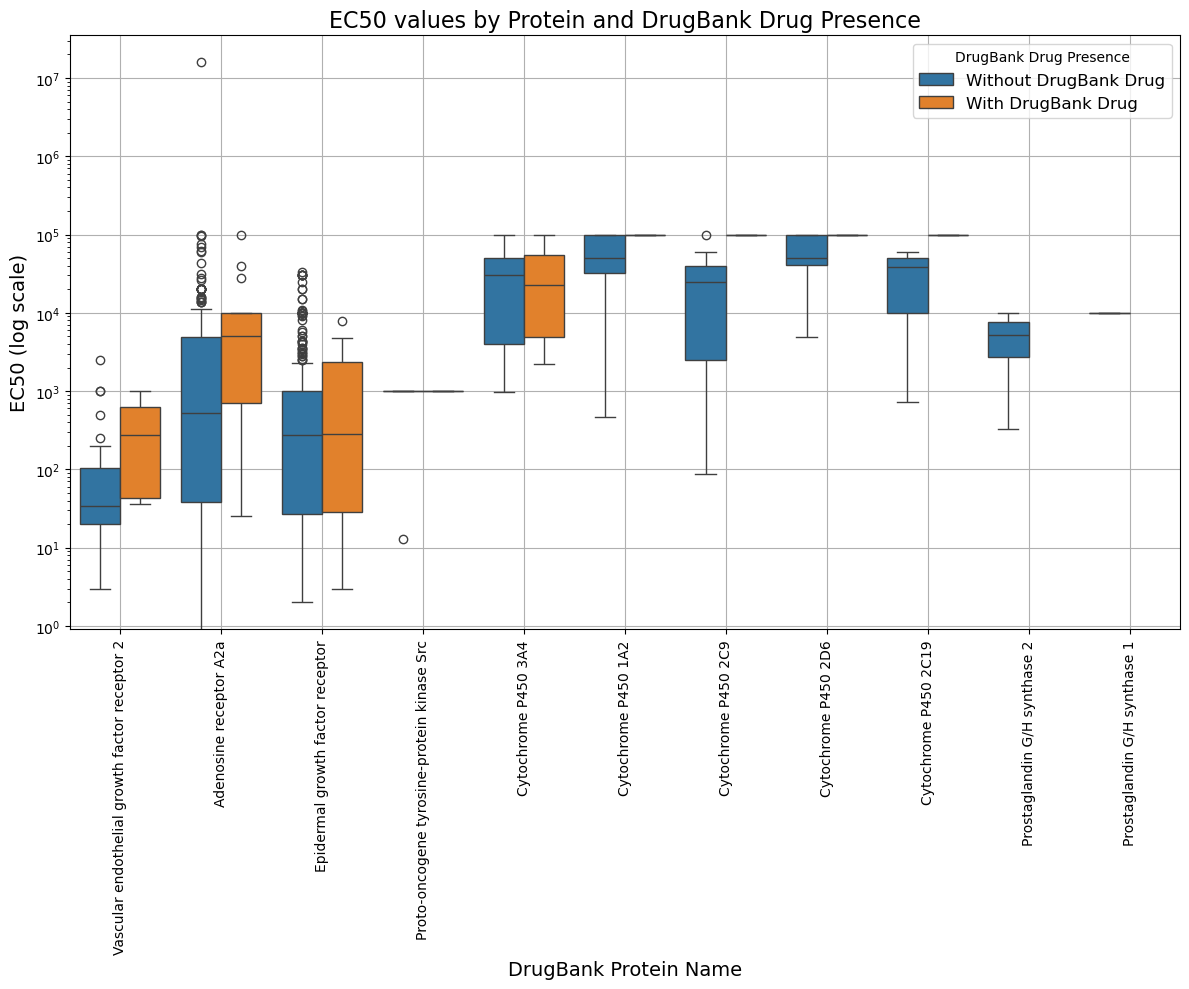

In [13]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['ec50'].notna()],  # Exclude rows with NaN `ki`
    x="target_name",
    y="ec50",
    hue="drugbank_drug_name_present"  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("EC50 values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("EC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid("y")
plt.show()

#### Selecting n largest elements of each group 

                         target_name drugbank_drug_name_present      ec50
62057            Cytochrome P450 3A4      Without DrugBank Drug  100000.0
96486            Cytochrome P450 3A4      Without DrugBank Drug  100000.0
89588            Cytochrome P450 3A4      Without DrugBank Drug   89000.0
62059            Cytochrome P450 3A4      Without DrugBank Drug   60000.0
62058            Cytochrome P450 3A4      Without DrugBank Drug   60000.0
...                              ...                        ...       ...
102975  Prostaglandin G/H synthase 2         With DrugBank Drug      <NA>
103005  Prostaglandin G/H synthase 2         With DrugBank Drug      <NA>
103030  Prostaglandin G/H synthase 2         With DrugBank Drug      <NA>
103031  Prostaglandin G/H synthase 2         With DrugBank Drug      <NA>
103239  Prostaglandin G/H synthase 2         With DrugBank Drug      <NA>

[16604 rows x 3 columns]


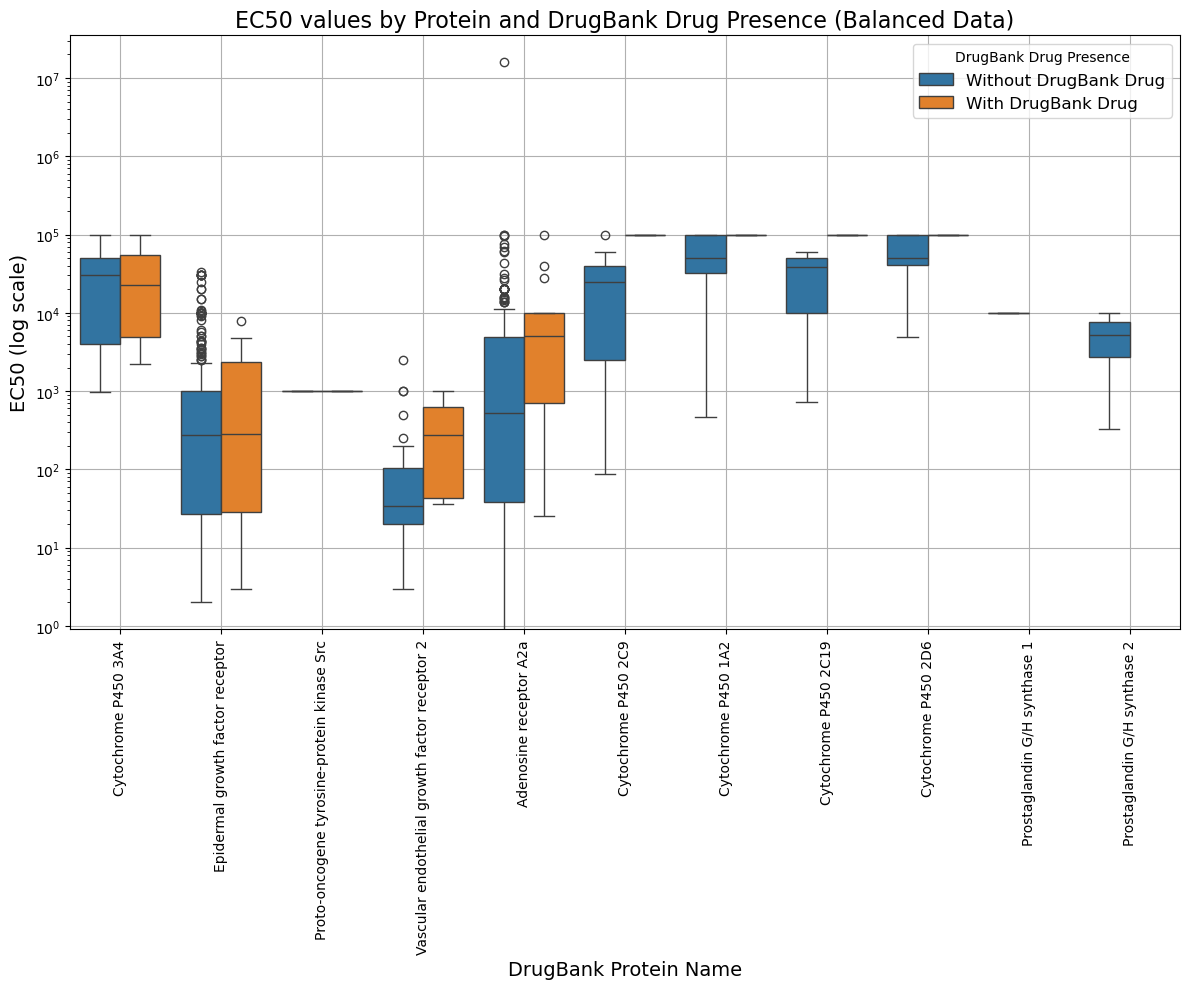

In [14]:
# Step 3: Group by `target_name` and select the top N largest values per group
balanced_data = pd.DataFrame()  # To store the balanced dataset
for target in filtered_df['target_name'].unique():
    # Get subsets for each hue
    group_with = filtered_df[
        (filtered_df['target_name'] == target) & 
        (filtered_df['drugbank_drug_name_present'] == 'With DrugBank Drug')
    ].nlargest(n=len(filtered_df), columns='ec50')  # Sort by `ec50`
    
    group_without = filtered_df[
        (filtered_df['target_name'] == target) & 
        (filtered_df['drugbank_drug_name_present'] == 'Without DrugBank Drug')
    ].nlargest(n=len(filtered_df), columns='ec50')
    
    # Find the smaller group size
    min_size = min(len(group_with), len(group_without))
    
    # Select the top N largest `ec50` values for both groups
    balanced_data = pd.concat([
        balanced_data,
        group_without.nlargest(n=min_size, columns='ec50'),
        group_with.nlargest(n=min_size, columns='ec50')
    ])

print(balanced_data[["target_name", "drugbank_drug_name_present", "ec50"]])

# Step 4: Plot the boxplot
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=balanced_data, 
    x="target_name",
    y="ec50",
    hue="drugbank_drug_name_present"
)

# Customize the plot
plt.yscale("log")
plt.xticks(rotation=90)
plt.title("EC50 values by Protein and DrugBank Drug Presence (Balanced Data)", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("EC50 (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid("y")
plt.show()


##### visualizing the number of drugs per protein

In [15]:
filtered_df.groupby(['target_name', 'drugbank_drug_name_present']).count()



index  \
target_name                                   drugbank_drug_name_present          
Adenosine receptor A2a                        With DrugBank Drug            468   
                                              Without DrugBank Drug       13519   
Cytochrome P450 1A2                           With DrugBank Drug            315   
                                              Without DrugBank Drug        3885   
Cytochrome P450 2C19                          With DrugBank Drug            264   
                                              Without DrugBank Drug        3210   
Cytochrome P450 2C9                           With DrugBank Drug            397   
                                              Without DrugBank Drug        5324   
Cytochrome P450 2D6                           With DrugBank Drug            424   
                                              Without DrugBank Drug        6211   
Cytochrome P450 3A4                           With DrugBank Drug            769   
                                              Without DrugBank Drug        9492   
Epidermal growth factor receptor              With DrugBank Drug           2474   
                                              Without DrugBank Drug       18565   
Prostaglandin G/H synthase 1                  With DrugBank Drug            960   
                                              Without DrugBank Drug        6480   
Prostaglandin G/H synthase 2                  With DrugBank Drug           1068   
                                              Without DrugBank Drug        8771   
Proto-oncogene tyrosine-protein kinase Src    With DrugBank Drug            363   
                                              Without DrugBank Drug        6189   
Vascular endothelial growth factor receptor 2 With DrugBank Drug            800   
                                              Without DrugBank Drug       13311   

                                                                             ki  \
target_name                                   drugbank_drug_name_present          
Adenosine receptor A2a                        With DrugBank Drug            413   
                                              Without DrugBank Drug       10201   
Cytochrome P450 1A2                           With DrugBank Drug             15   
                                              Without DrugBank Drug          44   
Cytochrome P450 2C19                          With DrugBank Drug              9   
                                              Without DrugBank Drug          50   
Cytochrome P450 2C9                           With DrugBank Drug             32   
                                              Without DrugBank Drug          98   
Cytochrome P450 2D6                           With DrugBank Drug             37   
                                              Without DrugBank Drug         113   
Cytochrome P450 3A4                           With DrugBank Drug             65   
                                              Without DrugBank Drug         146   
Epidermal growth factor receptor              With DrugBank Drug             33   
                                              Without DrugBank Drug         437   
Prostaglandin G/H synthase 1                  With DrugBank Drug             87   
                                              Without DrugBank Drug          28   
Prostaglandin G/H synthase 2                  With DrugBank Drug            110   
                                              Without DrugBank Drug          64   
Proto-oncogene tyrosine-protein kinase Src    With DrugBank Drug              8   
                                              Without DrugBank Drug         476   
Vascular endothelial growth factor receptor 2 With DrugBank Drug             24   
                                              Without DrugBank Drug         569   

                                                                            ph  \
target

### Kd

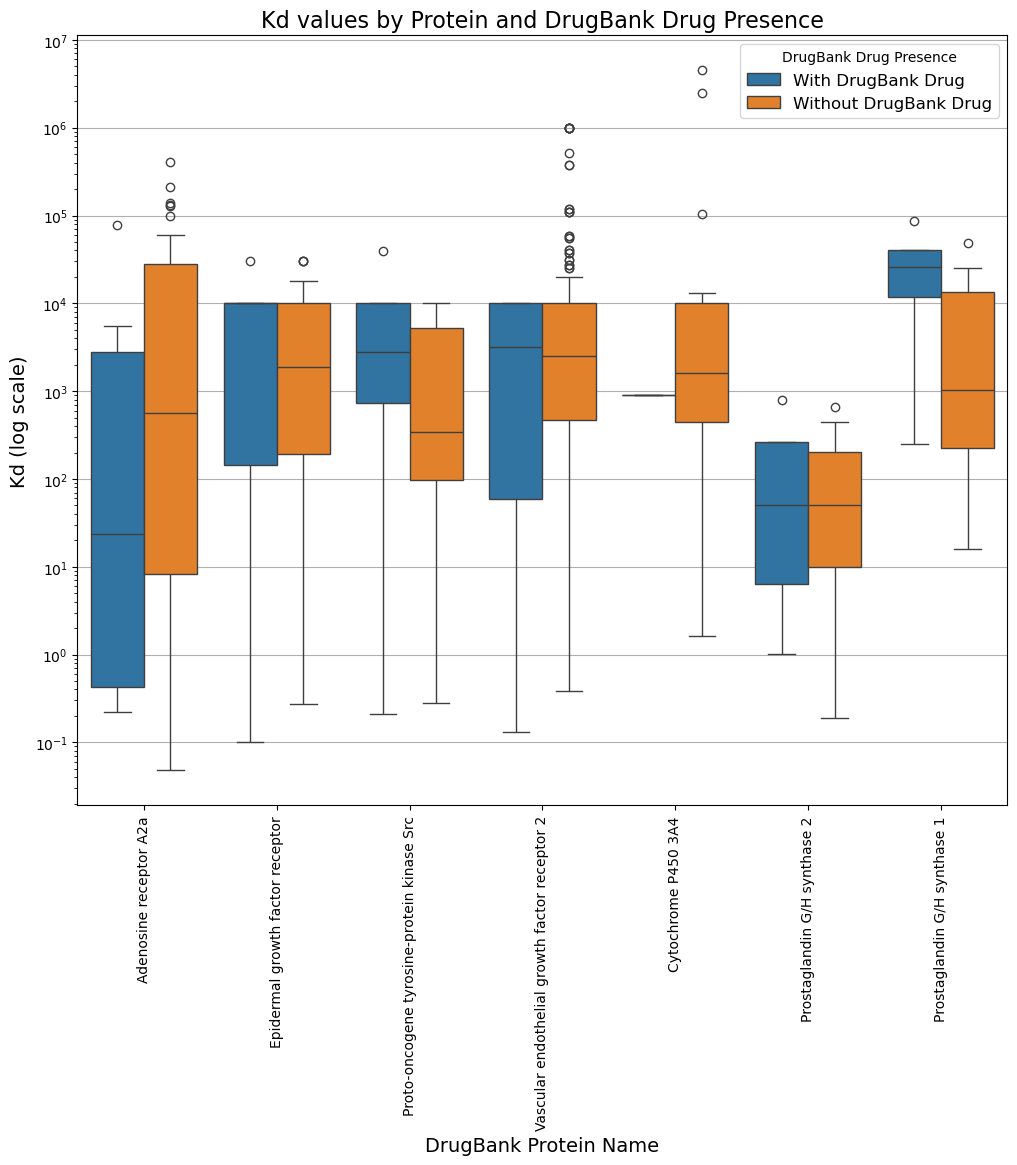

In [36]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=filtered_df[filtered_df['kd'].notna()].drop_duplicates(),  # Exclude rows with NaN `ki`
    x="target_name",
    y="kd",
    hue="drugbank_drug_name_present",  # Use the new column to separate groups
)
plt.yscale("log")  # Set y-axis to log scale
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Kd values by Protein and DrugBank Drug Presence", fontsize=16)
plt.xlabel("DrugBank Protein Name", fontsize=14)
plt.ylabel("Kd (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
#plt.tight_layout()
plt.grid(axis="y")
plt.show()

## Correlation matrix

In [37]:
chemical_param_list = ["ki", "kd", "ec50", "ic50"]

# Only cancer-related proteins
chemical_param_for_corr = filtered_df[chemical_param_list]
chemical_param_for_corr

# all proteins
merged_df_chemical_param = merged_df[chemical_param_list]

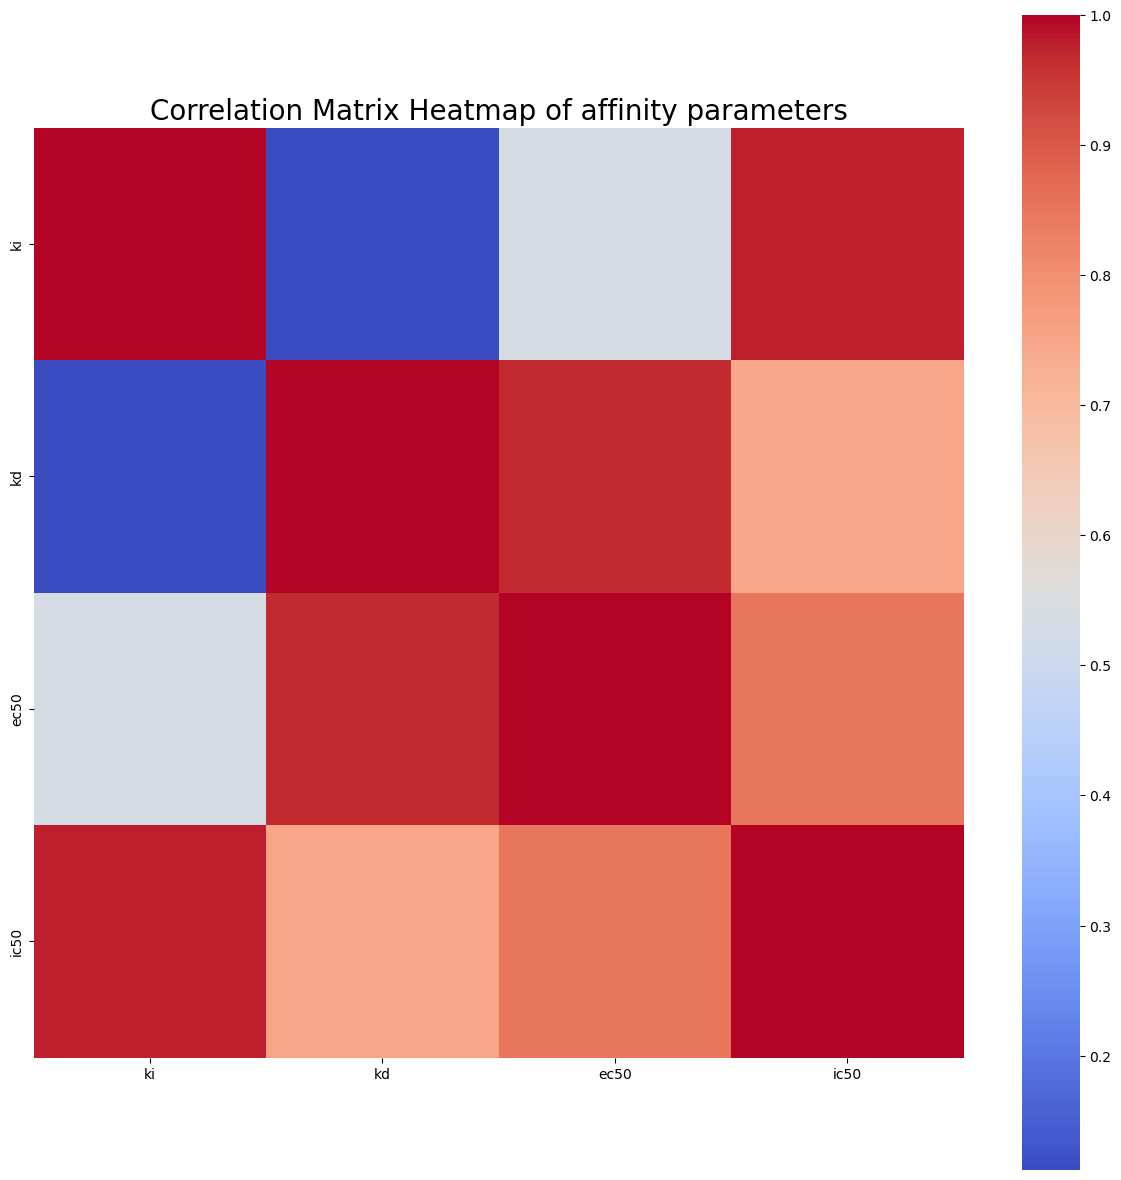

In [38]:
# Spearman's correlaiton coefficient 
correlation_matrix = merged_df_chemical_param.corr(method='pearson')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 15))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap of affinity parameters', size=20)
plt.show()

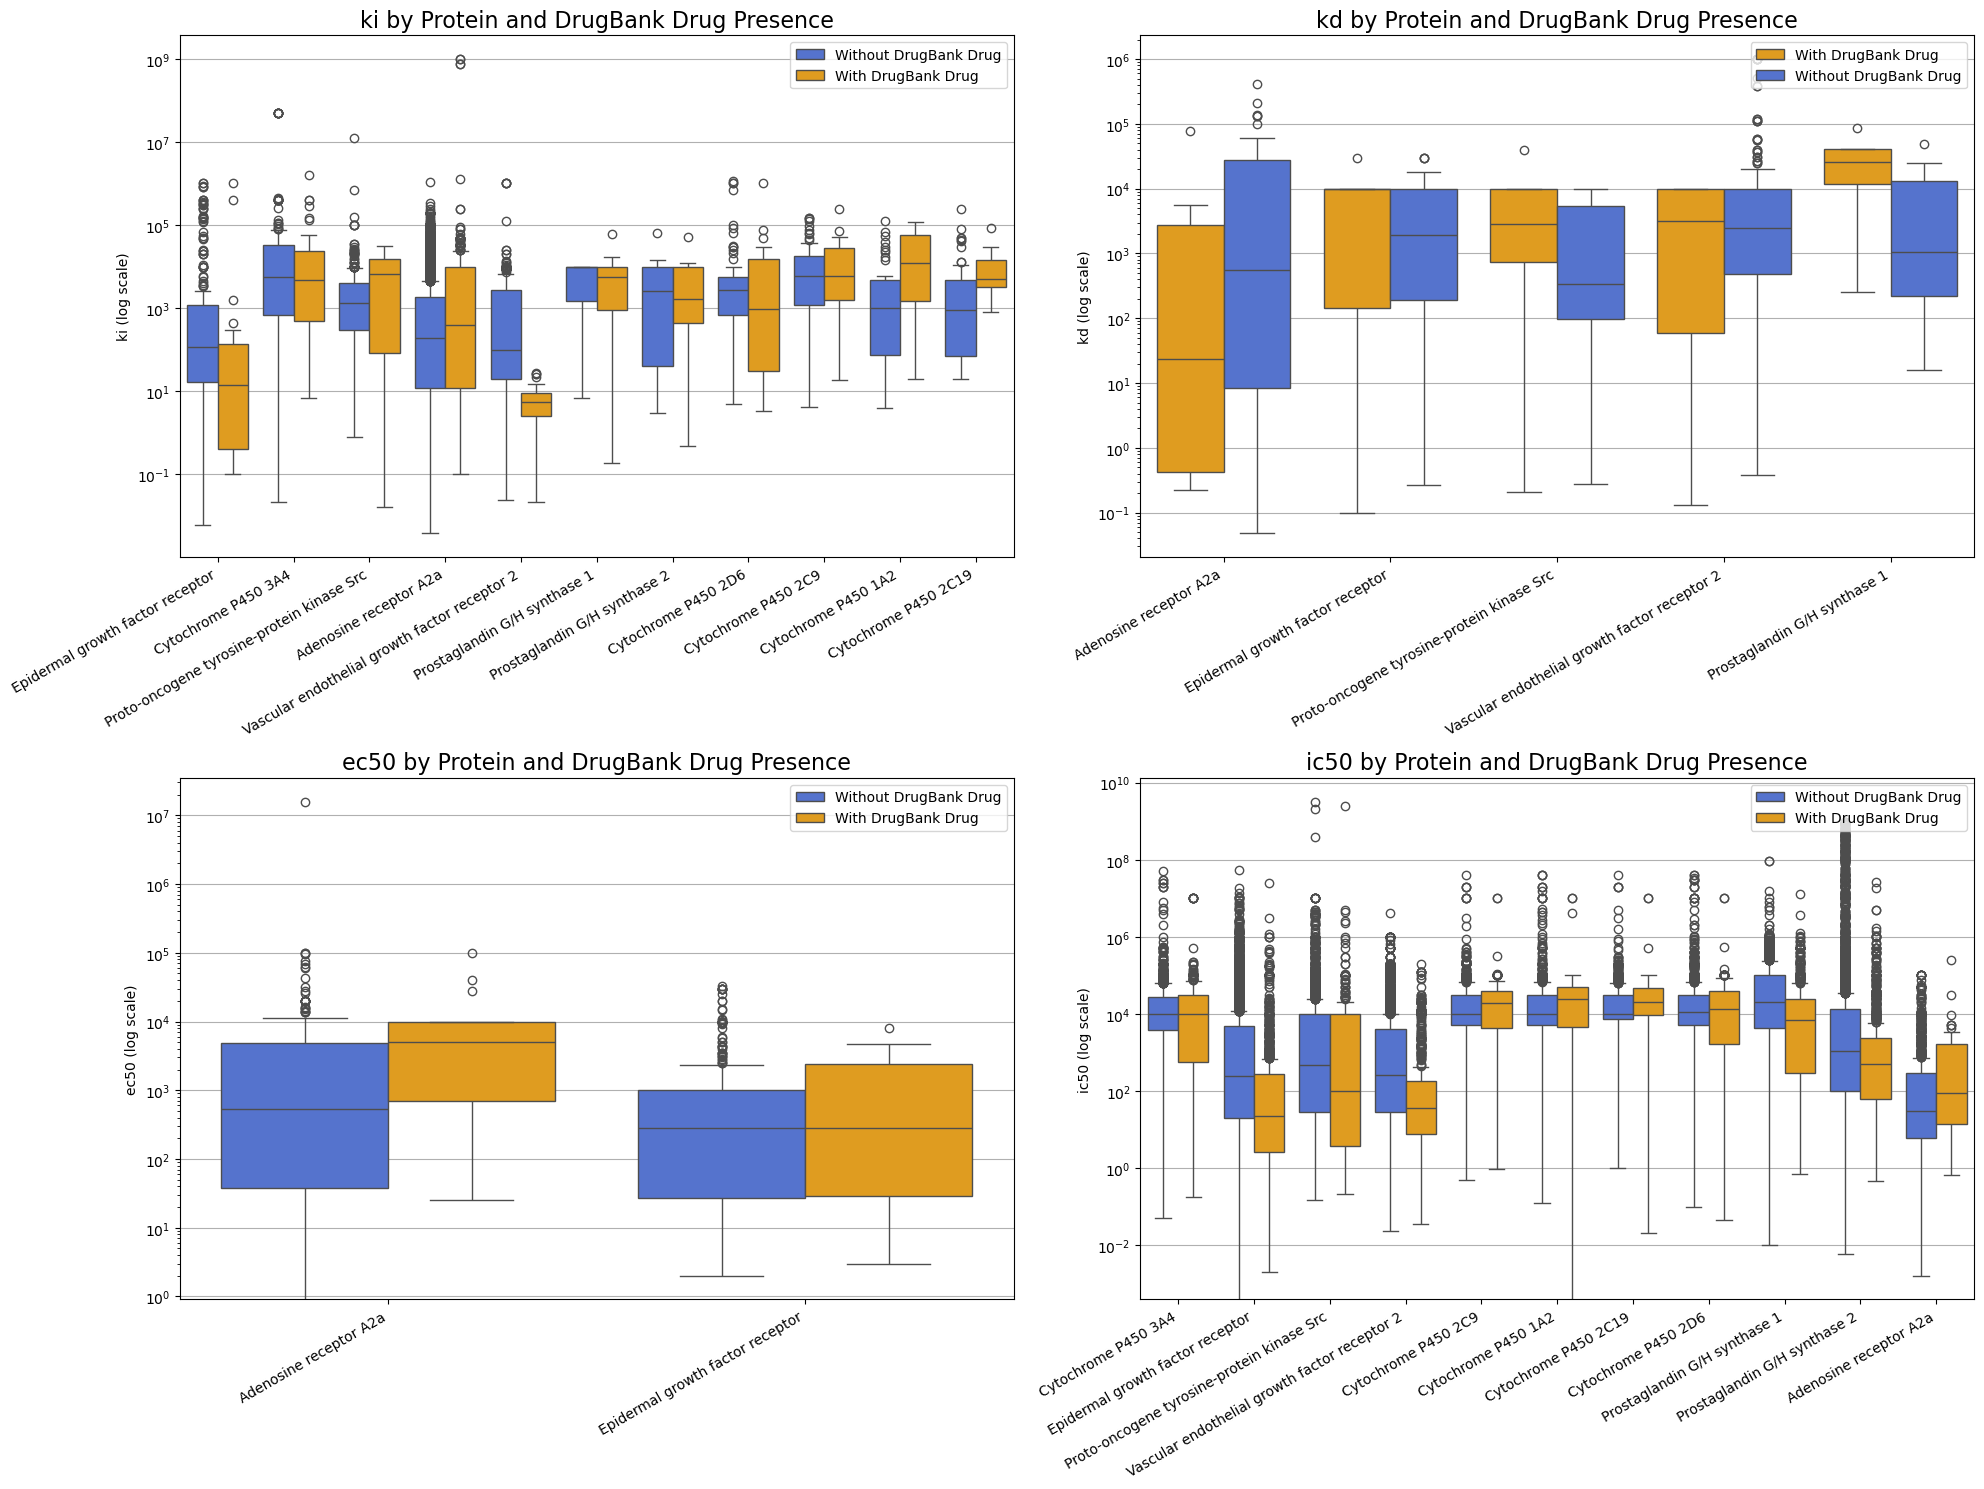

In [215]:
custom_palette = {
    "Without DrugBank Drug": "royalblue",    # Assign "blue" to "Present"
    "With DrugBank Drug": "orange",   # Assign "orange" to "Absent"
}

BOXPLOT_MINIMUM_COUNT = 5

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes = axes.flatten()

for i, col in enumerate(chemical_param_list):
    data = filtered_df[(filtered_df[col].notna())].drop_duplicates()

    counts = data.groupby(["target_name", "drugbank_drug_name_present"]).size().unstack(fill_value=0)
    valid_targets = counts[
        (counts["Without DrugBank Drug"] >= BOXPLOT_MINIMUM_COUNT) & (counts["With DrugBank Drug"] >= BOXPLOT_MINIMUM_COUNT)
    ].index
    filtered_data = data[data["target_name"].isin(valid_targets)]


    if not filtered_data.empty:

        sns.boxplot(
            data=filtered_data,
            x="target_name",
            y=col,
            hue="drugbank_drug_name_present",  # Group by DrugBank drug presence
            ax=axes[i], 
            palette=custom_palette,
            # width=0.2,
            # dodge=True
        )
        
        axes[i].set_yscale("log")
        axes[i].tick_params(axis='x', rotation=30)
        for tick in axes[i].get_xticklabels():
            tick.set_ha('right')

        axes[i].set_title(f"{col} by Protein and DrugBank Drug Presence", fontsize=16)
        axes[i].set_ylabel(f"{col} (log scale)", fontsize=10)
        axes[i].set_xlabel("")
        
        axes[i].legend(title="", fontsize=10, loc='upper right')
        axes[i].grid(axis="y")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


pH: <FloatingArray>
[<NA>, 7.5, 7.4, 7.6, 7.8, 8.0, 7.0, 5.5, 7.2, 7.1, 6.8, 8.4]
Length: 12, dtype: Float64
Temperatures: <FloatingArray>
[<NA>, 20.0, 25.0, 22.0, 30.0, 4.0, 23.0, 37.0, 27.0, 28.0]
Length: 10, dtype: Float64


Text(0, 0.5, 'température [°C]')

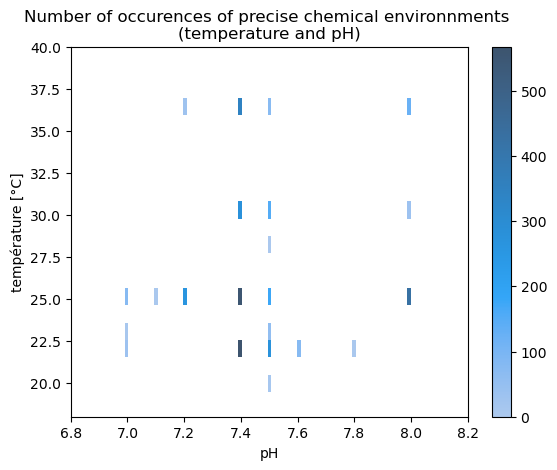

In [205]:
print("pH:", filtered_df["ph"].unique())
print("Temperatures:", filtered_df["temp"].unique())
sns.histplot(x="ph", y="temp", data=filtered_df, cbar=True)
plt.ylim([18, 40])
plt.xlim([6.8,8.2])
plt.title("Number of occurences of precise chemical environnments \n(temperature and pH)")
plt.xlabel("pH")
plt.ylabel("température [°C]")

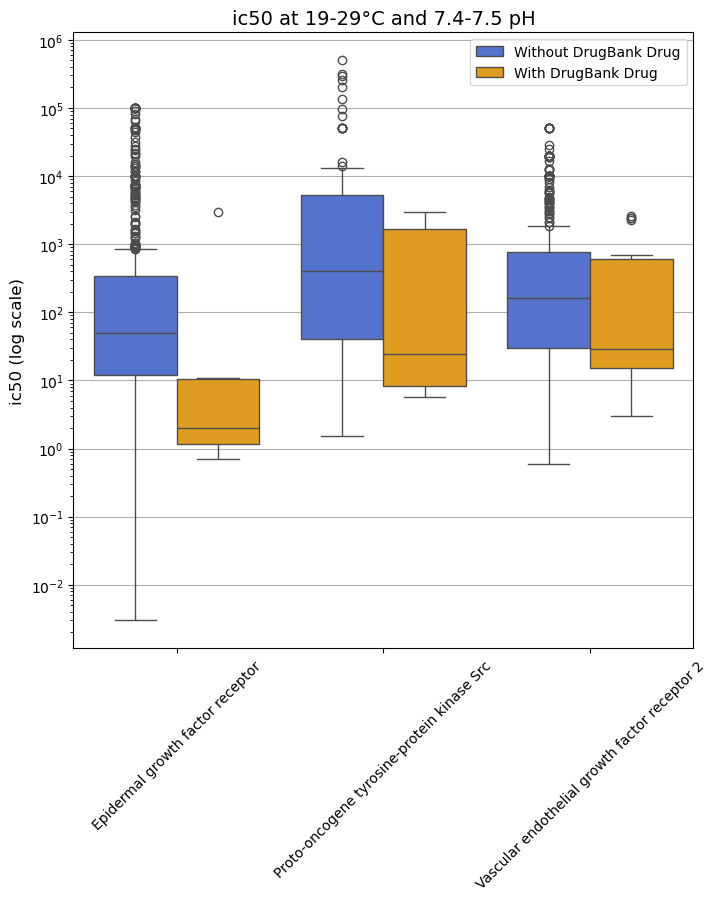

In [206]:
custom_palette = {
    "Without DrugBank Drug": "royalblue",
    "With DrugBank Drug": "orange",
}

temperatures = list(range(19, 30))
pH = [7.4, 7.5]
col = "ic50"

data = filtered_df[
    (filtered_df[col].notna()) &
    (filtered_df["ph"].isin(pH)) &
    (filtered_df["temp"].isin(temperatures))
].drop_duplicates()

counts = data.groupby(["target_name", "drugbank_drug_name_present"]).size().unstack(fill_value=0)
valid_targets = counts[
    (counts["Without DrugBank Drug"] >= BOXPLOT_MINIMUM_COUNT) & (counts["With DrugBank Drug"] >= BOXPLOT_MINIMUM_COUNT)
].index
filtered_data = data[data["target_name"].isin(valid_targets)]

if not filtered_data.empty:
    plt.figure(figsize=(8, 8))
    sns.boxplot(
        data=filtered_data,
        x="target_name",
        y=col,
        hue="drugbank_drug_name_present",
        palette=custom_palette
    )
    
    plt.yscale("log")
    
    plt.xticks(rotation=45)
    
    plt.title(f"{col} at {temperatures[0]}-{temperatures[-1]}°C and {pH[0]}-{pH[-1]} pH", fontsize=14)
    plt.ylabel(f"{col} (log scale)", fontsize=12)
    plt.xlabel("", rotation=30)
    plt.legend(title="")
    plt.grid(axis="y")
    
    plt.show()
else:
    print("No valid data available for the plot.")



## Bootstrapping

c:\Users\godenzi\Documents\ADA\ada-2024-project-hyperbabbage\Chemical_analysis.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return bootstrap_df


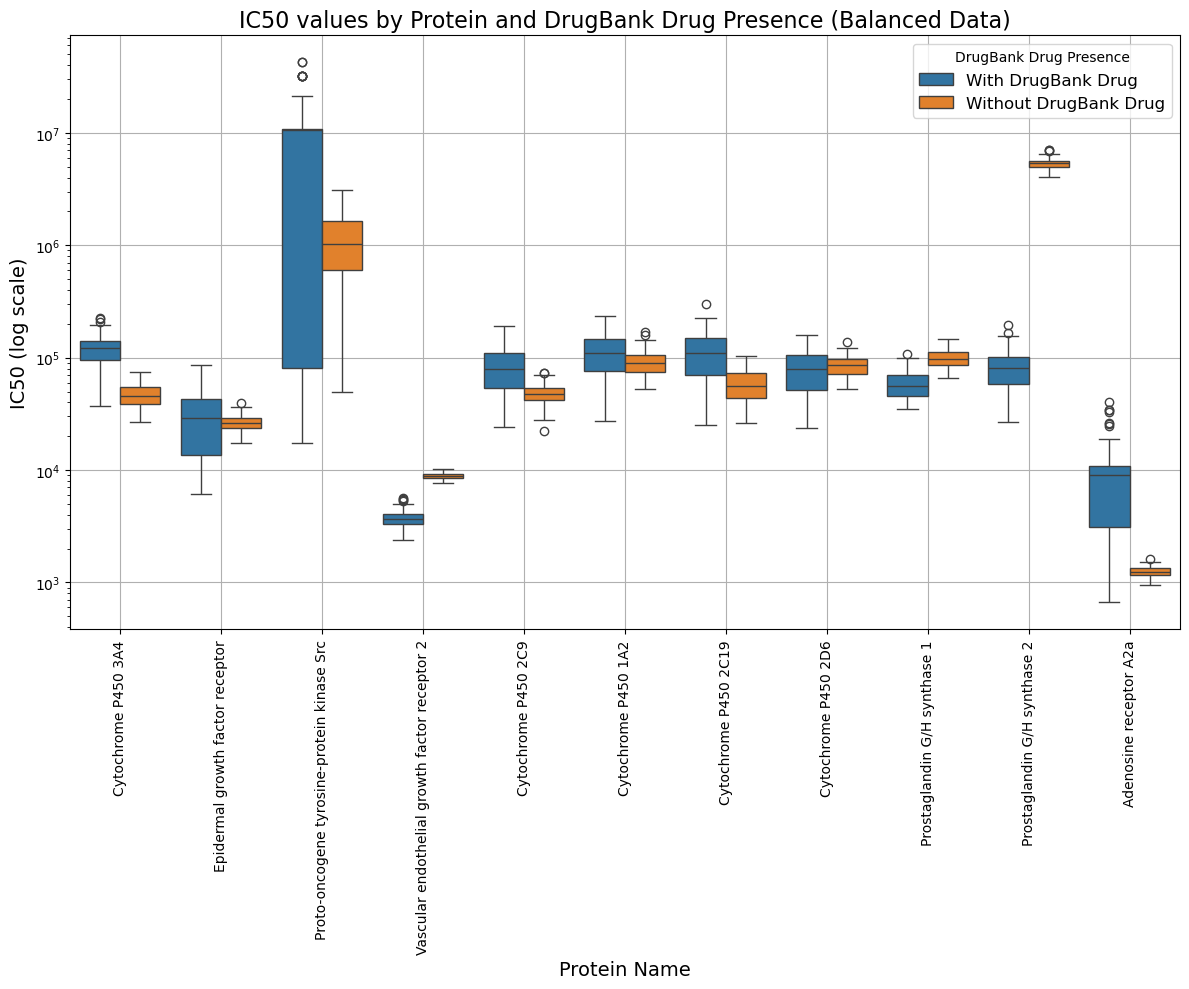

In [28]:

from Chemical_analysis import bootstrap, bootstrap_chemical_param

# select column of interest (ec50, ic50, kd, ki)
col = "ic50"

# Perform bootstrapping
chem_prop_df = bootstrap_chemical_param(filtered_df, column=col)

# plot the result
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(
    data=chem_prop_df, 
    x="target_name",
    y=col,
    hue="drugbank_drug_name_present"
)

# Customize the plot
plt.yscale("log")
plt.xticks(rotation=90)
plt.title(f"{col.upper()} values by Protein and DrugBank Drug Presence (Balanced Data)", fontsize=16)
plt.xlabel("Protein Name", fontsize=14)
plt.ylabel(f"{col.upper()} (log scale)", fontsize=14)
plt.legend(title="DrugBank Drug Presence", fontsize=12)
plt.tight_layout()
plt.grid("y")
plt.show()

In [25]:
from scipy.stats import mannwhitneyu


# Define a function to perform Mann-Whitney U test on grouped data
def mannwhitney_test(group, col):
    # Split data into two groups based on 'drugbank_drug_name_present'
    without_drug = group[group["drugbank_drug_name_present"] == "Without DrugBank Drug"][col].values
    with_drug = group[group["drugbank_drug_name_present"] == "With DrugBank Drug"][col].values
    
    # Ensure there are at least one sample in both groups
    if len(without_drug) > 0 and len(with_drug) > 0:
        u_stat, p_value = mannwhitneyu(without_drug, with_drug, alternative='two-sided')
    else:
        u_stat, p_value = np.nan, np.nan  # Handle cases with insufficient data
    
    return pd.Series({"u_stat": u_stat, "p_value": p_value})

# Apply the Mann-Whitney test to each group with a specified column
results = chem_prop_df.groupby("target_name").apply(lambda group: mannwhitney_test(group, col)).reset_index()


results



C:\Users\godenzi\AppData\Local\Temp\ipykernel_5344\2722747332.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = chem_prop_df.groupby("target_name").apply(lambda group: mannwhitney_test(group, col)).reset_index()


,target_name,u_stat,p_value
0,Adenosine receptor A2a,14.0,3.899684e-34
1,Cytochrome P450 1A2,153.0,2.370662e-32
2,Cytochrome P450 2C19,4.0,2.889194e-34
3,Cytochrome P450 2C9,10.0,3.459069e-34
4,Cytochrome P450 2D6,1920.0,5.295645e-14
5,Cytochrome P450 3A4,58.0,1.449043e-33
6,Epidermal growth factor receptor,10000.0,2.562144e-34
7,Prostaglandin G/H synthase 1,10000.0,2.562144e-34
8,Prostaglandin G/H synthase 2,10000.0,2.562144e-34
9,Proto-oncogene tyrosine-protein kinase Src,1164.0,7.142897e-21


### Analyzing non-drug lignads

In [26]:
without_drug_df = filtered_df[filtered_df["drugbank_drug_name_present"] == "Without DrugBank Drug"]
without_drug_df_Vascular = without_drug_df[without_drug_df["target_name"]=='Adenosine receptor A2a'].dropna(how="all")
ligand_list = without_drug_df_Vascular["ligand_name"].unique()
ligand_list

filtered_subset = filtered_df[filtered_df["ligand_name"].isin(ligand_list)]

non_drug_ligand_without_Vas = filtered_subset[filtered_subset["target_name"] != "Vascular endothelial growth factor receptor 2"]

non_drug_ligand_without_Vas[col].median()
#without_drug_df_Vascular["ki"].median()

34.6

In [27]:
bs_non_drug = chem_prop_df[chem_prop_df["drugbank_drug_name_present"]=="Without DrugBank Drug"]
bs_vas = bs_non_drug[bs_non_drug["target_name"]=='Adenosine receptor A2a']

bs_vas[col].median()

405.4120429982363

## Overall comparisons 

In [ ]:
Drug_df = filtered_df[filtered_df.drugbank_drug_name_present=='With DrugBank Drug']
Drug_df

drug_protein = Drug_df.groupby("target_name")[["ki", "kd", "ic50", "ec50"]].median()
drug_protein

,ki,kd,ic50,ec50
target_name,,,,
Adenosine receptor A2a,401.0,23.5,87.0,5012.0
Cytochrome P450 1A2,12000.0,<NA>,24400.0,100000.0
Cytochrome P450 2C19,5100.0,<NA>,20900.0,100000.0
Cytochrome P450 2C9,5800.0,<NA>,19500.0,100000.0
Cytochrome P450 2D6,960.0,<NA>,13115.0,100000.0
Cytochrome P450 3A4,4700.0,900.0,10000.0,22950.0
Epidermal growth factor receptor,14.0,10000.0,23.0,286.0
Prostaglandin G/H synthase 1,5700.0,25900.0,6800.0,<NA>
Prostaglandin G/H synthase 2,1700.0,50.0365,490.0,<NA>


In [ ]:
no_drug_df = filtered_df[filtered_df.drugbank_drug_name_present=="Without DrugBank Drug"]
no_drug_df

no_drug_protein = no_drug_df.groupby("target_name")[["ki", "kd", "ic50", "ec50"]].median()
no_drug_protein

,ki,kd,ic50,ec50
target_name,,,,
Adenosine receptor A2a,192.0,560.0,30.0,529.0
Cytochrome P450 1A2,1010.0,<NA>,10000.0,50000.0
Cytochrome P450 2C19,925.0,<NA>,10000.0,38000.0
Cytochrome P450 2C9,6000.0,<NA>,10000.0,25118.86
Cytochrome P450 2D6,2800.0,<NA>,11000.0,50000.0
Cytochrome P450 3A4,5745.0,1600.0,10000.0,30000.0
Epidermal growth factor receptor,117.0,1900.0,250.0,278.5
Prostaglandin G/H synthase 1,10000.0,1040.0,20000.0,10000.0
Prostaglandin G/H synthase 2,2600.0,50.0,1090.0,5165.0


In [ ]:
comparing_drugs_no_drugs = no_drug_protein > drug_protein
comparing_drugs_no_drugs.sum(axis=0)

ki      7
kd      2
ic50    5
ec50    1
dtype: Int32

# Cancer processes

In [ ]:
# joins all targeted proteins 
pattern_protein_names = '|'.join(rf"\b{re.escape(term)}\b" for term in cancer_proteins)
pattern_gene_names =  '|'.join(rf"\b{re.escape(term)}\b" for term in genes_uniprot)
pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

#test
#pattern_protein_names

# extract rows based on the columns that contain cancer_keywords 
all_cancer_molec_df = merged_df[
    #merged_df['drugbank_drug_unii'].str.contains(pattern_protein_names, case=False, na=False) |
    #merged_df['swissprot_target_chain_name'].str.contains(pattern_protein_names, case=False, na=False) |
    merged_df['swissprot_protein_id'].str.contains(pattern_gene_names, case=False, na=False) |
    merged_df['drugbank_protein_name'].str.contains(pattern_protein_names, case=False, na=False)|
    merged_df['target_name'].str.contains(pattern_highly_studied, case=False, na=False)
    #merged_df['target_name'].isin(highly_studied_proteins)
]
all_cancer_molec_df.reset_index(inplace=True)


print(all_cancer_molec_df.shape)
all_cancer_molec_df.head()

(141527, 39)


,index,ki,ph,temp,ic50,ec50,kd,kon,koff,doi,...,drugbank_drug_class_superclass,drugbank_drug_synonyms,drugbank_drug_categories,drugbank_drug_patent_approved,drugbank_drug_interaction,Matched_On,drugbank_protein_name,drugbank_protein_general_function,drugbank_protein_specific_function,drugbank_protein_organism
0,142,<NA>,<NA>,<NA>,50000.0,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3775,<NA>,7.5,20.0,800.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3776,<NA>,7.5,20.0,220.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3777,<NA>,7.5,20.0,160.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3778,<NA>,7.5,20.0,58.0,<NA>,<NA>,<NA>,<NA>,10.1021/jm970124v,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merging dataframes

In [ ]:
df = pd.merge(all_cancer_molec_df, protein_classes, left_on ="drugbank_protein_name", right_on="Gene", how="left")
for col in df.columns:
    print(col)

index
ki
ph
temp
ic50
ec50
kd
kon
koff
doi
target_name
ligand_name
pubchem_cid
chebi_id
chembl_id
drugbank_id
kegg_id
zinc_id
smiles
inchi_key
bindingdb_id
swissprot_target_chain_name
swissprot_target_chain_entry_name
swissprot_protein_id
Unique_ID
drugbank_drug_name
drugbank_drug_unii
drugbank_drug_toxicity
drugbank_drug_class_kingdom
drugbank_drug_class_superclass
drugbank_drug_synonyms
drugbank_drug_categories
drugbank_drug_patent_approved
drugbank_drug_interaction
Matched_On
drugbank_protein_name
drugbank_protein_general_function
drugbank_protein_specific_function
drugbank_protein_organism
Gene
Gene synonym
Ensembl
Gene description
Uniprot
Chromosome
Position
Protein class
Biological process
Molecular function
Disease involvement
Evidence
HPA evidence
UniProt evidence
NeXtProt evidence
RNA tissue specificity
RNA tissue distribution
RNA tissue specificity score
RNA tissue specific nTPM
RNA single cell type specificity
RNA single cell type distribution
RNA single cell type specificit

### Plots

In [ ]:
drug_biological_process = df[df["drugbank_drug_name"].notna()].groupby("Biological process")[["drugbank_drug_name"]].count().reset_index()
drug_biological_process

,Biological process,drugbank_drug_name
0,"Adaptive immunity, Apoptosis, Immunity, Innate...",2
1,"Adaptive immunity, Immunity, Innate immunity",64
2,"Angiogenesis, Differentiation, Host-virus inte...",2
3,"Angiogenesis, Differentiation, Host-virus inte...",16
4,"Angiogenesis, Lipid metabolism, Phagocytosis",65
5,Apoptosis,7
6,"Apoptosis, Autophagy, Cell adhesion, DNA damag...",1
7,"Apoptosis, Biological rhythms, Cell cycle, Hos...",1
8,"Apoptosis, Carbohydrate metabolism, Glucose me...",6
9,"Autophagy, Cell adhesion, Endocytosis, Lipid m...",37


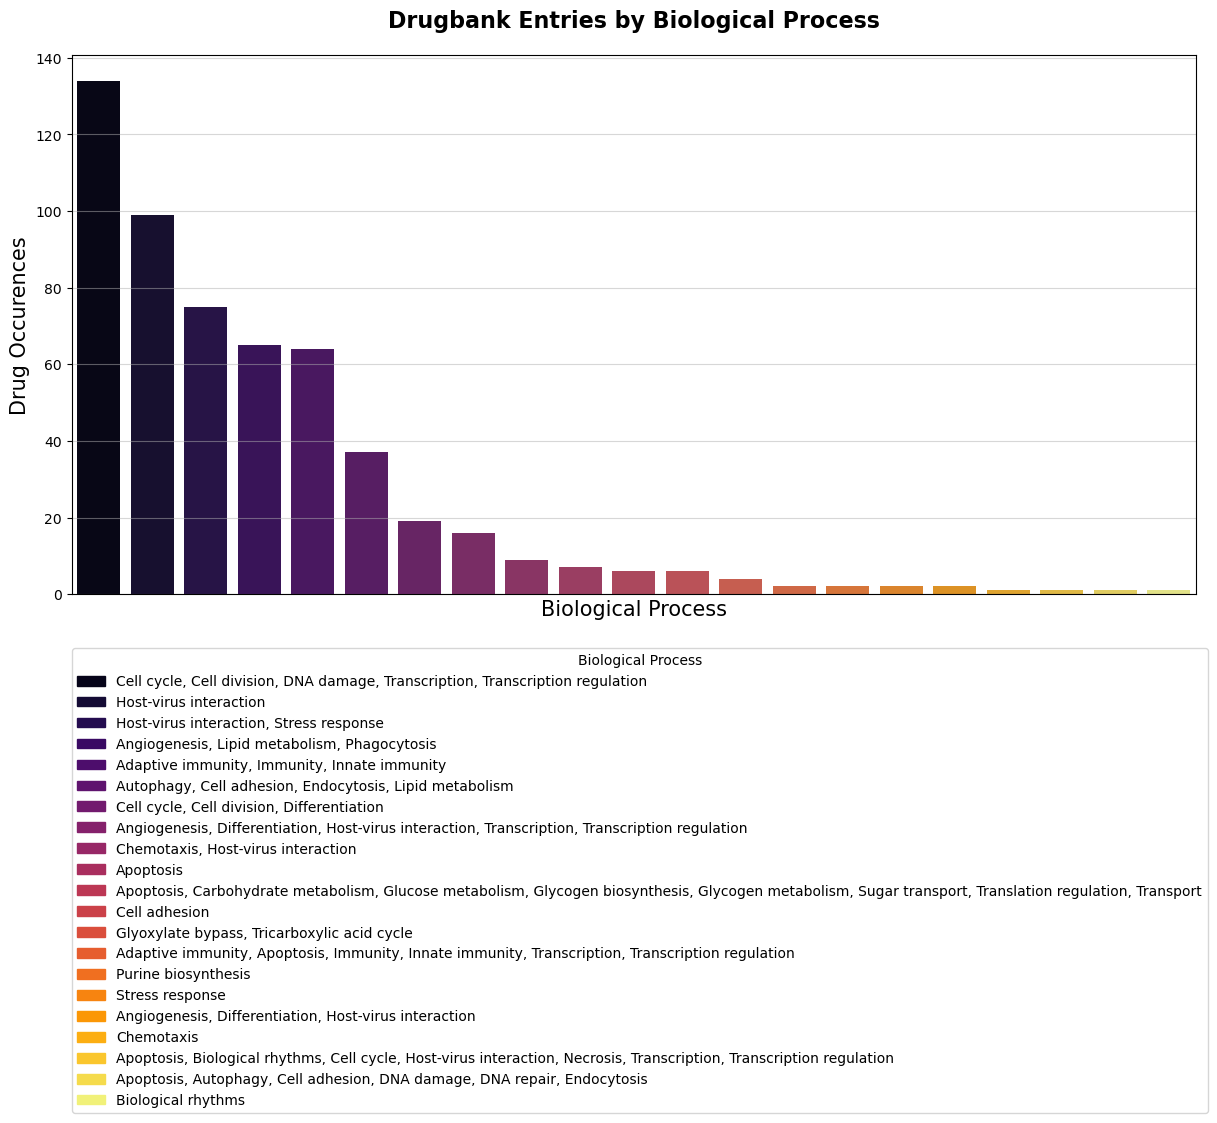

In [ ]:
# Set figure size
plt.figure(figsize=(14.5, 7))

# sorting value
drug_biological_process = drug_biological_process.sort_values(by="drugbank_drug_name", ascending=False)

# Create the barplot
ax = sns.barplot(
    x="Biological process",
    y="drugbank_drug_name",
    hue="Biological process",
    data=drug_biological_process,
    palette="inferno"
)

# Remove x-tick labels
plt.xticks([])

# Create a custom legend
# Extract unique categories from 'Biological process'
categories = drug_biological_process["Biological process"].unique()
palette = sns.color_palette(n_colors=len(categories), palette="inferno")  # Get the default color palette
legend_handles = [mpatches.Patch(color=palette[i], label=category) for i, category in enumerate(categories)]

# Add the legend with custom colors
plt.legend(
    handles=legend_handles,
    title="Biological Process",
    bbox_to_anchor=(0.0, -0.1), 
    loc='upper left',
    borderaxespad=0.

)

# Customize plot appearance
plt.grid(axis="y", which="both", alpha=0.5)

plt.title(
    "Drugbank Entries by Biological Process",
    fontsize=16,
    fontweight="bold",
    pad=20
)

plt.xlabel("Biological Process", size=15)
plt.ylabel("Drug Occurences", size=15)
#plt.yscale("log")
#plt.tight_layout()

# Show plot
plt.show()


C:\Users\godenzi\AppData\Local\Temp\ipykernel_18284\2489664596.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  center_circle = Circle((0, 0), 0.60, color='white', edgecolor='black', linewidth=1.5)


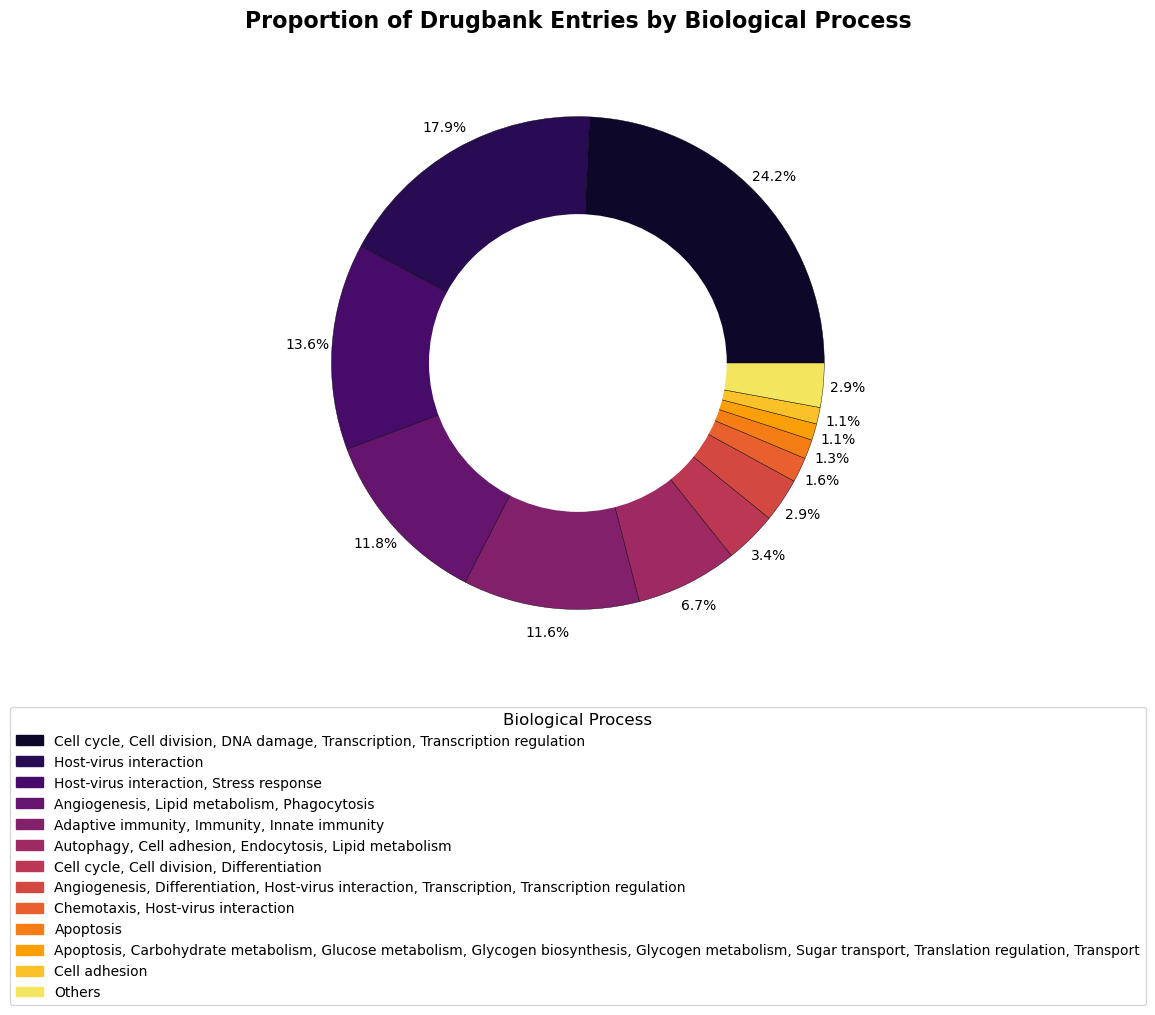

In [ ]:
# Extract sizes and categories
sizes = drug_biological_process["drugbank_drug_name"].values
categories = drug_biological_process["Biological process"].values

# Calculate total and percentages
total_size = sum(sizes)
percentages = (sizes / total_size) * 100

# Create a new DataFrame with aggregated "Others"
data = pd.DataFrame({"Biological process": categories, "sizes": sizes, "percentages": percentages})
others = data[data["percentages"] < 1].sum()  # Sum small categories into "Others"
data = data[data["percentages"] >= 1]  # Keep large categories
if not others.empty:
    data = pd.concat([data, pd.DataFrame({"Biological process": ["Others"], "sizes": [others["sizes"]], "percentages": [others["percentages"]]})])

# Generate a color palette for the updated categories
categories = data["Biological process"].values
sizes = data["sizes"].values
palette = sns.color_palette("inferno", n_colors=len(categories))
colors = [palette[i] for i in range(len(categories))]

# Create the pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,  # Remove default labels
    colors=colors,
    autopct='%1.1f%%',  # Percentage values
    startangle=0,
    wedgeprops={"edgecolor": "black", "linewidth": 0.3},
    pctdistance=1.1,  # Position percentages outside the pie
    textprops={'fontsize': 10}
)

# Remove the center to create a donut chart with a black edge
center_circle = Circle((0, 0), 0.60, color='white', edgecolor='black', linewidth=1.5)
plt.gca().add_artist(center_circle)

# Add custom legend below the chart
legend_handles = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
plt.legend(
    handles=legend_handles,
    title="Biological Process",
    bbox_to_anchor=(0.5, -0.3),  # Position legend below the chart
    loc='center',
    borderaxespad=0.,
    fontsize=10,
    title_fontsize=12,
    ncol=1  # Arrange legend entries into two columns
)

# Add a visually distinct title
plt.title(
    "Proportion of Drugbank Entries by Biological Process",
    fontsize=16,
    fontweight="bold",
    pad=20
)

# Optimize layout for neatness
#plt.tight_layout()

# Display the chart
plt.show()
